In [1]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU ,Bidirectional
from keras.layers import Reshape
# For PLotting we will use these library

import matplotlib.pyplot as plt

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,21651.183594,27078406594
2023-02-11,21651.841797,21891.410156,21618.449219,21870.875000,21870.875000,16356226232
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,21788.203125,17821046406


In [3]:
# Step 2: Feature engineering
data['RSI'] = ta.rsi(data.Close, length=15)
data['EMA_short'] = ta.ema(data.Close, length=20)
data['EMA_long'] = ta.ema(data.Close, length=100)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop([ 'Close'], axis=1, inplace=True)
# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.tail(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2974 entries, 2014-12-25 to 2023-02-14
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2974 non-null   float64
 1   High       2974 non-null   float64
 2   Low        2974 non-null   float64
 3   Adj Close  2974 non-null   float64
 4   Volume     2974 non-null   int64  
 5   RSI        2974 non-null   float64
 6   EMA_short  2974 non-null   float64
 7   EMA_long   2974 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 209.1 KB


,Open,High,Low,Adj Close,Volume,RSI,EMA_short,EMA_long
Date,,,,,,,,
2023-02-05,23332.248047,23423.435547,22841.759766,22955.666016,19564262605,63.070038,22435.092412,19776.192933
2023-02-06,22954.021484,23119.279297,22692.025391,22760.109375,23825006542,60.523024,22466.046409,19835.280387
2023-02-07,22757.267578,23310.974609,22756.257812,23264.291016,27187964471,64.484885,22542.069704,19903.181588
2023-02-08,23263.416016,23367.958984,22731.097656,22939.398438,25371367758,60.306257,22579.910536,19963.304694
2023-02-09,22946.566406,22996.437500,21773.974609,21819.039062,32572572185,48.656922,22507.446586,20000.051909
2023-02-10,21819.005859,21941.185547,21539.392578,21651.183594,27078406594,47.193524,22425.897730,20032.747586
2023-02-11,21651.841797,21891.410156,21618.449219,21870.875000,16356226232,49.330527,22373.038422,20069.146149
2023-02-12,21870.902344,22060.994141,21682.828125,21788.203125,17821046406,48.538550,22317.339823,20103.186881
2023-02-13,21787.000000,21898.414062,21460.087891,21808.101562,23918742607,48.750732,22268.840941,20136.947568


In [4]:
# Split the data into training and test sets
train_df = data[:int(len(data)*0.8)]
test_df = data[int(len(data)*0.8):]
data.shape

(2974, 8)

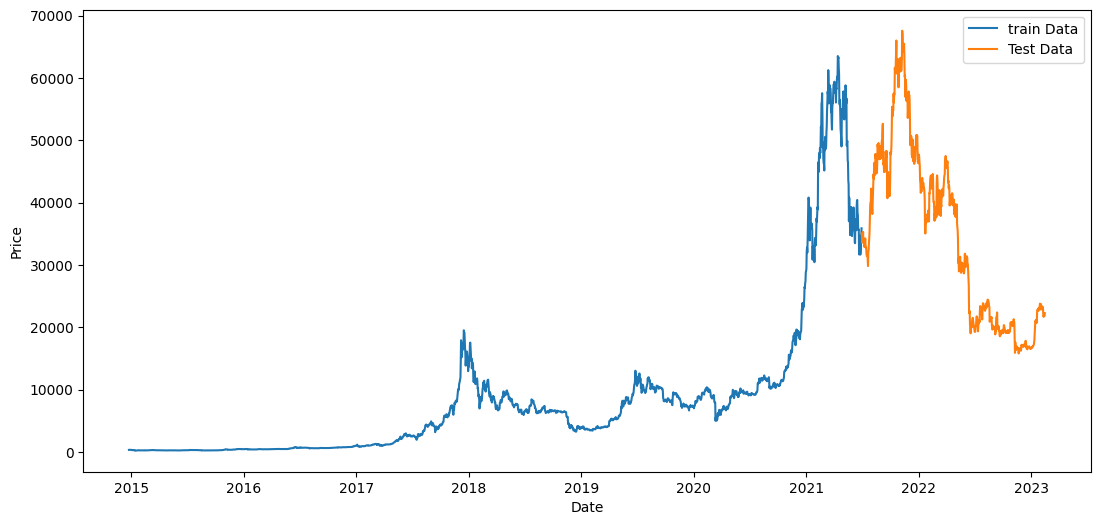

In [5]:
plt.figure(figsize=(13,6))
plt.plot(train_df['Adj Close'], label='train Data')
plt.plot(test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()




In [6]:

train_plot = train_df
train_plot.loc[:, 'type'] = 'Train'
test_plot = test_df
test_plot.loc[:, 'type'] = 'Test'

df = pd.concat([train_plot, test_plot])
df = df.reset_index()
df = df.rename(columns={'index': 'Date'})

fig = px.line(df, x='Date', y='Adj Close', color='type' )
fig.update_layout(title='Train and Test Bitcoin Data',font_size=15, font_color='black',legend_title_text=' Parameters')
fig.show()







C:\Users\pc\AppData\Local\Temp\ipykernel_2536\3946717447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_plot.loc[:, 'type'] = 'Train'
C:\Users\pc\AppData\Local\Temp\ipykernel_2536\3946717447.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_plot.loc[:, 'type'] = 'Test'


In [7]:
train_x = train_df.index
train_y = train_df['Adj Close']
test_x = test_df.index
test_y = test_df['Adj Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_x, y=train_y, name='train Data'))
fig.add_trace(go.Scatter(x=test_x, y=test_y, name='Test Data'))

fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Price',
    title='Price over time'
)

fig.show()

In [8]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2379 entries, 2014-12-25 to 2021-06-29
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2379 non-null   float64
 1   High       2379 non-null   float64
 2   Low        2379 non-null   float64
 3   Adj Close  2379 non-null   float64
 4   Volume     2379 non-null   int64  
 5   RSI        2379 non-null   float64
 6   EMA_short  2379 non-null   float64
 7   EMA_long   2379 non-null   float64
 8   type       2379 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 185.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 595 entries, 2021-06-30 to 2023-02-14
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       595 non-null    float64
 1   High       595 non-null    float64
 2   Low        595 non-null    float64
 3   Adj Close  595 non-null    float64
 4  

In [9]:
# Preprocess the data
X_train = train_df.drop(['Adj Close','type'], axis=1).values
y_train = train_df['Adj Close'].values

X_test = test_df.drop(['Adj Close','type'], axis=1).values
y_test = test_df['Adj Close'].values

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

x_train (2379, 7)
y_train (2379,)
X_test (595, 7)
y_test (595,)


In [10]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = y_train.reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = y_test.reshape(-1, 1)
y_test = scaler.fit_transform(y_test)
print('y_train',y_train.shape)
print('y_test', y_test.shape)

y_train (2379, 1)
y_test (595, 1)


In [11]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])

X_train (2379, 1, 7)
y_train (2379, 1)
X_test (595, 1, 7)
Y_test (595, 1)
X_train.shape[1] 1
X_train.shape[2] 7


In [12]:
# Step 6: Building the LSTM model (cont.)

model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True,activation= 'tanh'))
model.add(Dropout(0.2))
model.add(Reshape((1, 100))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)
model.add(Bidirectional(LSTM(75, return_sequences=True,activation= 'tanh')))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(75,activation= 'tanh')))
model.add(Dropout(0.25))
model.add(Reshape((1, 150))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)
model.add(GRU(50, activation=  "tanh"))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()
"""""
model = Sequential()
model.add(LSTM(100, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Reshape((1, 100))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)
model.add(Bidirectional(LSTM(75, activation='tanh')))
model.add(Dropout(0.3))
model.add(Reshape((1, 150))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)
model.add(GRU(50, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mean_absolute_error'])
model.summary()"""


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            43200     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 1, 100)            0         
                                                                 
 reshape (Reshape)           (None, 1, 100)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 1, 150)           105600    
 l)                                                              
                                                        

'""\nmodel = Sequential()\nmodel.add(LSTM(100, activation=\'tanh\', input_shape=(X_train.shape[1], X_train.shape[2])))\nmodel.add(Dropout(0.2))\nmodel.add(Reshape((1, 100))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)\nmodel.add(Bidirectional(LSTM(75, activation=\'tanh\')))\nmodel.add(Dropout(0.3))\nmodel.add(Reshape((1, 150))) # Add a Reshape layer to convert output shape to (batch_size, timesteps, features)\nmodel.add(GRU(50, activation=\'tanh\'))\nmodel.add(Dropout(0.3))\nmodel.add(Dense(1))\nmodel.compile(loss=\'mean_squared_error\', optimizer=\'adam\', metrics=[\'accuracy\', \'mean_absolute_error\'])\nmodel.summary()'

In [13]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/1000
75/75 [==============================] - 39s 115ms/step - loss: 0.0202 - accuracy: 8.4069e-04 - mean_absolute_error: 0.0812 - val_loss: 0.0026 - val_accuracy: 0.0034 - val_mean_absolute_error: 0.0379
Epoch 2/1000
75/75 [==============================] - 2s 28ms/step - loss: 0.0021 - accuracy: 8.4069e-04 - mean_absolute_error: 0.0233 - val_loss: 0.0028 - val_accuracy: 0.0034 - val_mean_absolute_error: 0.0439
Epoch 3/1000
75/75 [==============================] - 2s 26ms/step - loss: 0.0017 - accuracy: 8.4069e-04 - mean_absolute_error: 0.0213 - val_loss: 0.0022 - val_accuracy: 0.0034 - val_mean_absolute_error: 0.0393
Epoch 4/1000
75/75 [==============================] - 2s 28ms/step - loss: 0.0013 - accuracy: 8.4069e-04 - mean_absolute_error: 0.0191 - val_loss: 0.0019 - val_accuracy: 0.0034 - val_mean_absolute_error: 0.0353
Epoch 5/1000
75/75 [==============================] - 2s 27ms/step - loss: 0.0014 - accuracy: 8.4069e-04 - mean_absolute_error: 0.0196 - val_loss: 0.0041 

In [14]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history

    plt.figure(figsize=(16,5))
    plt.plot(history['val_mean_absolute_error'])
    plt.plot(history['mean_absolute_error'])
    plt.legend(['val_mean_absolute_error', 'mean_absolute_error'])
    plt.title('mean_absolute_error')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()




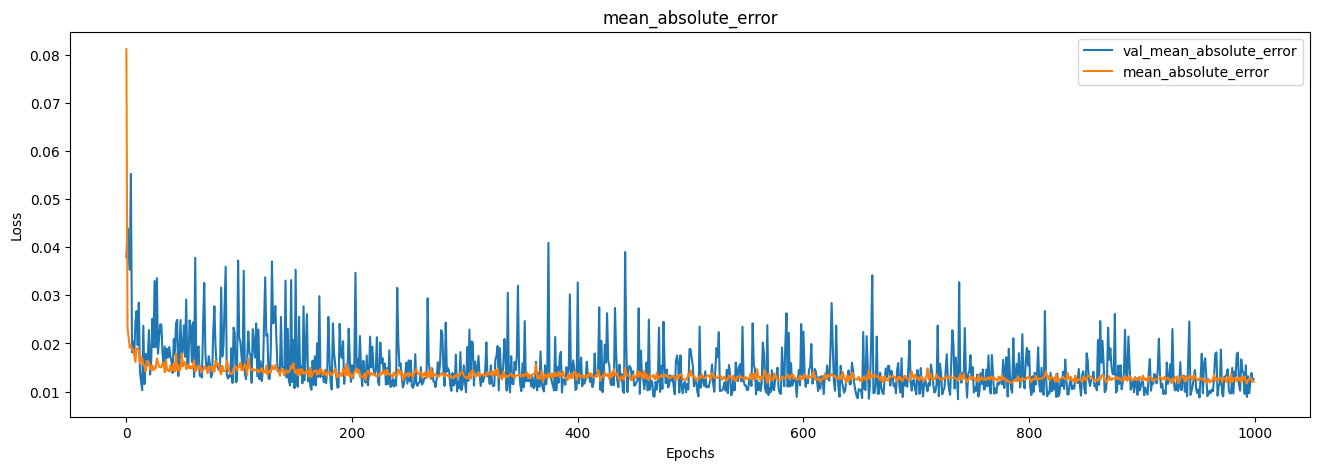

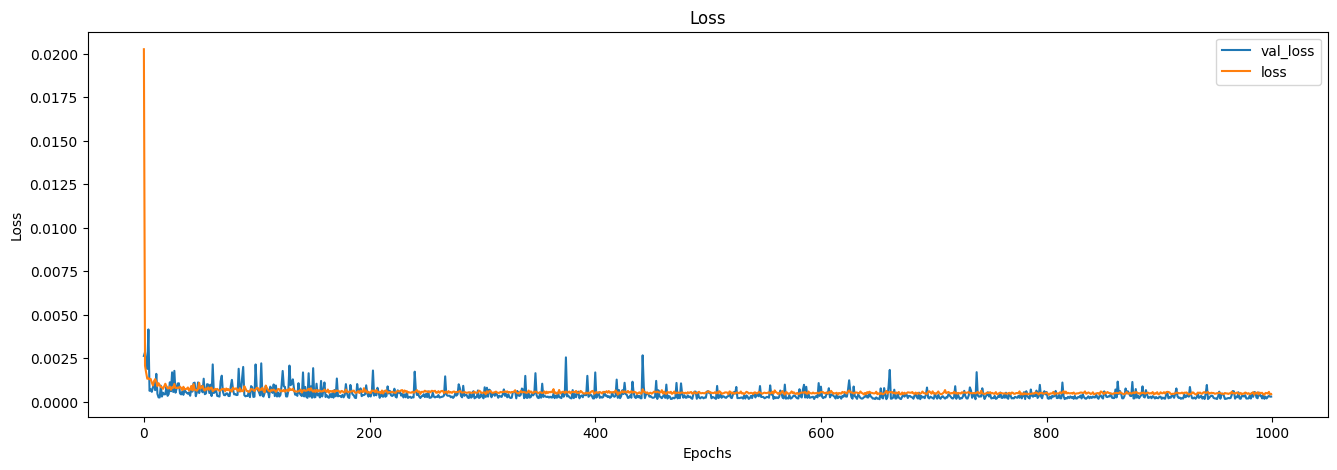

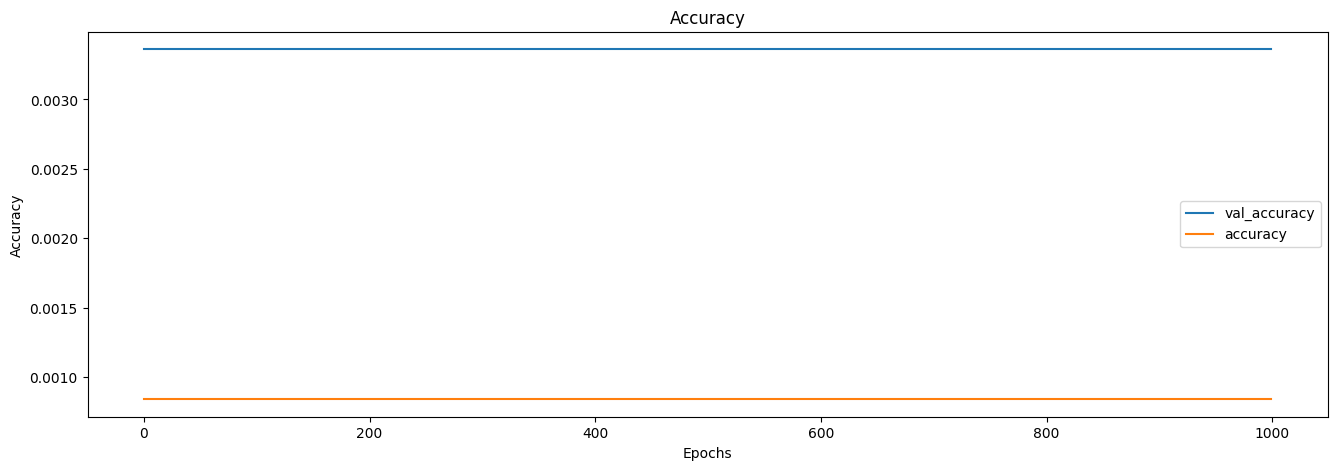

In [15]:
visualize_training_results(history)

In [16]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:' ,score)

Test loss: [0.0002883152337744832, 0.0033613445702940226, 0.012591085396707058]


In [17]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)

# convert to original data 
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

#evaluat
mse = mean_squared_error(y_test, y_pred )
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))



print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))
# This for LSTM 2layer - Bidirectional 2layer - GRU 1layer - 1000 epoache

19/19 [==============================] - 5s 7ms/step
y_pred (595, 1)
y_test (595, 1)
MAPE: 1.8921%
RMSE: 879.2091
MSE: 773008.5783
MAE:651.9609


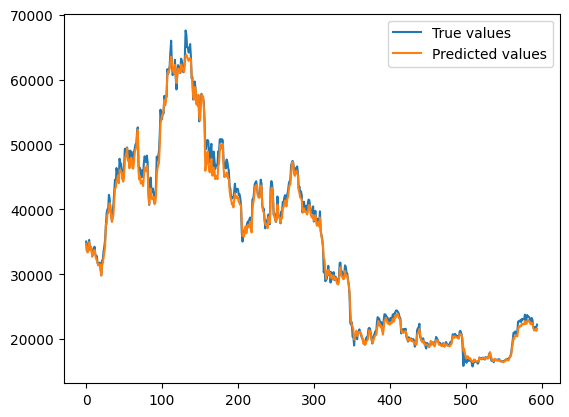

In [18]:
# Plot the true values and predicted values
plt.plot(y_test, label='True values')
plt.plot(y_pred, label='Predicted values')

# Add a legend and show the plot
plt.legend()
plt.show()

In [19]:
y_pred_df = pd.DataFrame(y_pred, columns=[ "Adj Close"])
y_test_df = pd.DataFrame(y_test, columns=[ "Adj Close"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=prediction_dates, end=today, freq='D')
test_dates = pd.date_range(start=test,end=today, freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)

In [20]:
y_test_df

,Adj Close
Date,
2021-07-01,35040.835938
2021-07-02,33572.117188
2021-07-03,33897.046875
2021-07-04,34668.546875
2021-07-05,35287.781250
...,...
2023-02-11,21651.183594
2023-02-12,21870.875000
2023-02-13,21788.203125


In [21]:
y_pred_df

,Adj Close
Date,
2021-07-01,34672.324219
2021-07-02,33631.867188
2021-07-03,33348.445312
2021-07-04,34076.535156
2021-07-05,34938.914062
...,...
2023-02-11,21354.638672
2023-02-12,21375.769531
2023-02-13,21427.177734


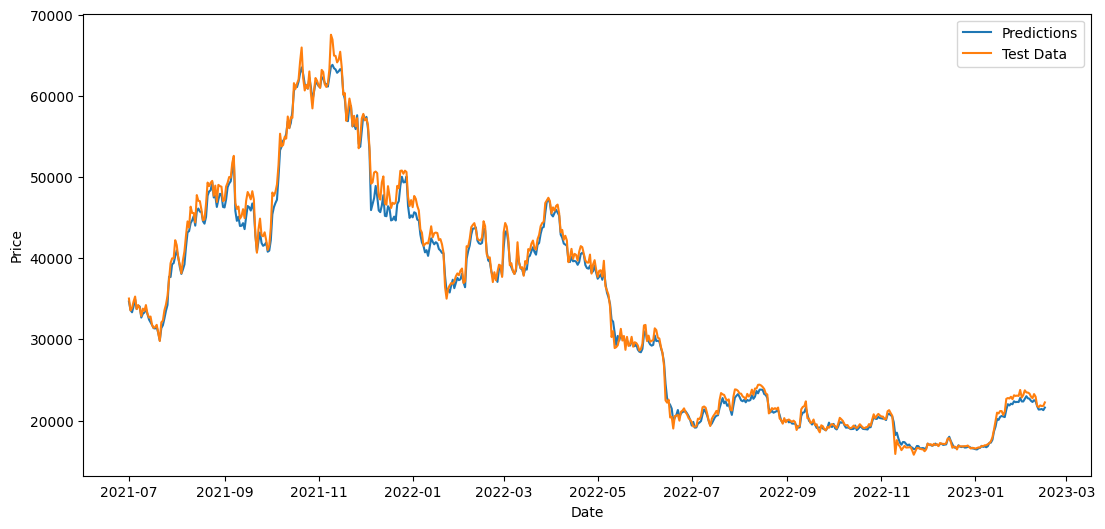

In [22]:
plt.figure(figsize=(13,6))
plt.plot(y_pred_df['Adj Close'], label='Predictions')
plt.plot(y_test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [23]:

names = cycle(['Predictions','Test Data'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_pred_df['Adj Close'], name='Predictions',
                         line=dict(width=2, color='blue')))
fig.add_trace(go.Scatter(x=y_test_df.index, y=y_test_df['Adj Close'], name='Test Data',
                         line=dict(width=2, color='red')))
fig.update_layout(xaxis_title='Date', yaxis_title='Price', font_size=15, font_color='black',legend_title_text=' Parameters')
fig.show()


In [24]:
# Calculate mean absolute percentage error (MAPE)
def mape(y_true, y_pred):
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

mape_value = mape(y_test, y_pred)
print(f'MAPE: {mape_value:.4f}%')

MAPE: 1.8921%


In [25]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))

smape: 1.9068%
